## 1. Get the dataset ##

In [1]:
import pandas as pd
import numpy as np
import json


# training data

with open('dataset/MathQA/train.json') as f:
    data = json.loads(f.read())
    
train_df = pd.DataFrame(data)

print('training problems number: ', train_df['Problem'].count())
print(train_df.groupby(['category'])['Problem'].count())

train_df.head(5)

training problems number:  29837
category
gain            5120
general        13273
geometry        2117
other           1814
physics         7063
probability      450
Name: Problem, dtype: int64


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category
0,the banker ' s gain of a certain sum due 3 yea...,"""explanation : t = 3 years r = 10 % td = ( bg ...","a ) rs . 400 , b ) rs . 300 , c ) rs . 500 , d...",a,"divide(multiply(const_100, divide(multiply(36,...","multiply(n2,const_100)|multiply(n0,n1)|divide(...",gain
1,average age of students of an adult school is ...,"""explanation : let the original no . of studen...","a ) 1200 , b ) 120 , c ) 360 , d ) 240 , e ) n...",d,"multiply(divide(subtract(multiply(add(32, 4), ...","add(n2,n3)|multiply(n1,n2)|multiply(n1,#0)|sub...",general
2,sophia finished 2 / 3 of a book . she calculat...,let xx be the total number of pages in the boo...,"a ) 229 , b ) 270 , c ) 877 , d ) 266 , e ) 281",b,"divide(90, subtract(const_1, divide(2, 3)))","divide(n0,n1)|subtract(const_1,#0)|divide(n2,#1)",general
3,120 is what percent of 50 ?,"""50 * x = 120 - - > x = 2.4 - - > 2.4 expresse...","a ) 5 % , b ) 240 % , c ) 50 % , d ) 2 % , e )...",b,"multiply(divide(120, 50), const_100)","divide(n0,n1)|multiply(#0,const_100)|",gain
4,there are 10 girls and 20 boys in a classroom ...,"if girls is 10 and boys is 20 , then 10 / 20 ....","a ) 1 / 2 , b ) 1 / 3 , c ) 1 / 5 , d ) 10 / 3...",a,"divide(10, 20)","divide(n0,n1)",other


## 2. Get the content of correct answers from the options 

In [2]:
def get_correct_ans(train_df):
    # get the correct answer from the options in the dataset
    
    answers = list()
    for i in range(len(train_df)):
        options = train_df.iloc[i]['options']+" ,"
        tab = train_df.iloc[i]['correct']
        index_s = options.find(tab+" ) ")+3
        index_len = options[index_s:].find(',')
        ans = options[index_s:index_s+index_len]
        answers.append(ans)

    answers = pd.Series(answers)
    return answers

In [3]:
cor_answers = get_correct_ans(train_df)
print(cor_answers)

0         rs . 400 
1              240 
2              270 
3            240 % 
4            1 / 2 
            ...    
29832        1 : 2 
29833       d ) 98 
29834         - 12 
29835          242 
29836       twelve 
Length: 29837, dtype: object


In [4]:
cor_answers[cor_answers.str.contains(' one ')]

3865      one 
10527     one 
dtype: object

## 3. Normalization

#### normalizing function 30^10 2/3 10% 5:8
#### that can be used in the answers and problems

In [5]:
import re

def add_space(sen):
    return " "+sen+" "

def replace_fraction(sen):
    # replace all string like "2 / 3 "
    pattern = re.compile(r'[0-9]+\s\/\s[0-9]+\s')    
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' / ')
            new_results.append(str(int(nums[0])/int(nums[1]))[:8]+' ')
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_percentage(sen):
    # replace all string like "20 %"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s%')   
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' ')
            new_results.append(str(round(float(nums[0])/100, 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_ratio(sen):
    # replace all string like " 2 : 3" "0.5 : 0.33 : 0.25"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s\:\s[0-9]+\.?[0-9]*')
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' : ')
            new_results.append(str(round(float(nums[0])/(float(nums[0])+float(nums[1])), 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_power(sen):
    # replace all string like "  30 ^ 10 "
    pass
    return sen

def replace_numword(sen):
    sen = sen.replace(' one ', ' 1 ')
    sen = sen.replace(' two ', ' 2 ')
    sen = sen.replace(' three ', ' 3 ')
    sen = sen.replace(' four ', ' 4 ')
    sen = sen.replace(' five ', ' 5 ')
    sen = sen.replace(' six ', ' 6 ')
    sen = sen.replace(' seven ', ' 7 ')
    sen = sen.replace(' eight ', ' 8 ')
    sen = sen.replace(' nine ', ' 9 ')
    sen = sen.replace(' ten ', ' 10 ')
    sen = sen.replace(' eleven ', ' 11 ')
    sen = sen.replace(' twelve ', ' 12 ')
    sen = sen.replace(' thirteen ', ' 13 ')
    sen = sen.replace(' fourteen ', ' 14 ')
    return sen

def replace_minus(sen):
    # replace all string like "- 20.5"
    pattern = re.compile(r'\-\s[0-9]+\.?[0-9]*')   
    results = pattern.findall(sen)
    
    if results != None:
        for i in results:
            sen = sen.replace(i, i.replace(" ", "", 1))
    return sen
    
def replace_punc(sen):
    # replace punctuation like "'" "." "|"
    sen = re.sub(r'\s[^\w\s]\s', ' ', sen)
    return sen


In [6]:
def answers_processing(answers):    
    # normalizing the correct answers
    # get the correct answers array that may contain NaN
    
    answers = answers.apply(replace_power)
    answers = answers.apply(replace_fraction)
    answers = answers.apply(replace_percentage)
    answers = answers.apply(replace_ratio)
    answers = answers.apply(replace_numword)
    answers = answers.apply(replace_minus)

    def separate_ans_numbers(sen):
        numbers = re.search(r'\-?[0-9]+\.?[0-9]*', sen)
        if numbers:
            numbers = numbers.group()
            return round(float(numbers), 4)
        else:
            return 
    answers = answers.apply(separate_ans_numbers)
    return answers

num_answers = answers_processing(cor_answers)

In [7]:
print(num_answers[425:435])

425      -8.00
426        NaN
427    3960.00
428       4.00
429     600.00
430        NaN
431      50.00
432      66.00
433       0.25
434     625.00
dtype: float64


In [8]:
num_answers[num_answers.isna()]

145     NaN
322     NaN
426     NaN
430     NaN
498     NaN
         ..
28960   NaN
29073   NaN
29413   NaN
29504   NaN
29626   NaN
Length: 156, dtype: float64

## 4. Get the subset according to the correct answers

In [9]:
def get_subset_index(answers):
    # get the subset index
    return answers[~answers.isna()].index

subset_index = get_subset_index(num_answers)
print(subset_index)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            29827, 29828, 29829, 29830, 29831, 29832, 29833, 29834, 29835,
            29836],
           dtype='int64', length=29681)


In [10]:
pre_train_problems = train_df['Problem'].iloc[subset_index].reset_index(drop=True)
print(pre_train_problems)

train_ans = num_answers.iloc[subset_index].reset_index(drop=True)
print(train_ans)

0        the banker ' s gain of a certain sum due 3 yea...
1        average age of students of an adult school is ...
2        sophia finished 2 / 3 of a book . she calculat...
3                              120 is what percent of 50 ?
4        there are 10 girls and 20 boys in a classroom ...
                               ...                        
29676    a man invests some money partly in 10 % stock ...
29677    average of 10 matches is 32 , how many runs on...
29678                  solve below question 2 x + 1 = - 23
29679                            calculate 85184 ÷ ? = 352
29680    7.51 8.22 7.86 8.36 8.09 7.83 8.30 8.01 7.73 8...
Name: Problem, Length: 29681, dtype: object
0        400.0000
1        240.0000
2        270.0000
3          2.4000
4          0.5000
           ...   
29676      0.3333
29677     98.0000
29678    -12.0000
29679    242.0000
29680     12.0000
Length: 29681, dtype: float64


## 5. Processing the problems and separate the text and numbers

#### 1) normalize the numbers and remove the punctuations

In [11]:
def problem_processing(problem):
    # processing the problems and normalize the numbers in the problem
    problem = problem.apply(add_space)
    problem = problem.apply(replace_power)
    problem = problem.apply(replace_fraction)
    problem = problem.apply(replace_percentage)
    problem = problem.apply(replace_ratio)
    problem = problem.apply(replace_numword)
    problem = problem.apply(replace_minus)
    problem = problem.apply(replace_punc)
    return problem

train_problems = problem_processing(pre_train_problems)

In [12]:
print(train_problems[:5])

0     the banker s gain of a certain sum due 3 year...
1     average age of students of an adult school is...
2     sophia finished 0.666666 of a book she calcul...
3                           120 is what percent of 50 
4     there are 10 girls and 20 boys in a classroom...
Name: Problem, dtype: object


#### 2) separate text and numbers in problems

In [13]:
def separate_numbers(sen):    
    pattarn = re.compile(r'\-?[0-9]+\.?[0-9]*')
    numbers = pattarn.findall(sen)
    numbers = [round(float(i), 4) for i in numbers]
    return numbers
    
def separate_text(sen):
    pattarn = re.compile(r'\-?[0-9]+\.?[0-9]*')
    numbers = pattarn.findall(sen)
    for i in numbers:
        sen = sen.replace(" "+i+" ", " ")
    return sen    

text = train_problems.apply(separate_text)
print(text)

numbers = train_problems.apply(separate_numbers)
print(numbers)

0         the banker s gain of a certain sum due years ...
1         average age of students of an adult school is...
2         sophia finished of a book she calculated that...
3                                      is what percent of 
4         there are girls and boys in a classroom what ...
                               ...                        
29676     a man invests some money partly in stock at a...
29677     average of matches is how many runs should sh...
29678                              solve below question x 
29679                                         calculate ? 
29680     a vending machine is designed to dispense oun...
Name: Problem, Length: 29681, dtype: object
0                                         [3.0, 0.1, 36.0]
1                                 [40.0, 120.0, 32.0, 4.0]
2                                           [0.6667, 90.0]
3                                            [120.0, 50.0]
4                                             [10.0, 20.0]
            

In [14]:
# example sentence
sen = "3.6 the banker ' s 3 : 8 : 7 gain of a - 0.66 certain 3.2549 sum due 3 years 21.5 % hence 5 : 8 at 10 % per annum is rs . 36 . what is the present worth ? = - 996"
sen = "solve below question 2 x + 1 = - 23"
print(sen)
sen = add_space(sen)
sen = replace_power(sen)
sen = replace_fraction(sen)
sen = replace_percentage(sen)
sen = replace_ratio(sen)
sen = replace_minus(sen)
sen = replace_punc(sen)
print(sen)
print(separate_numbers(sen))
print(separate_text(sen))


solve below question 2 x + 1 = - 23
 solve below question 2 x 1 -23 
[2.0, 1.0, -23.0]
 solve below question x 


## 4. Processing

### processing text ###

In [15]:
max_token = 0
for t in text:
    if len(t) > max_token:
        max_token = len(t)
print("the max tokens in the texts: ", max_token)

the max tokens in the texts:  745


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

max_features = 5000

# build a word vocab that contains top 5000 most frequent words
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(text)

print("token vocab length:", len(tok.word_index))
# print(tok.word_index)

x_train_seq = tok.texts_to_sequences(text)

# get the length and max length of text sequence in each sentence
seq_length = list()
max_seq = 0
for i in x_train_seq:
    seq_length.append(len(i))
max_seq = max(seq_length)
print("max sequence length: ", max_seq)


token vocab length: 8096
max sequence length:  136


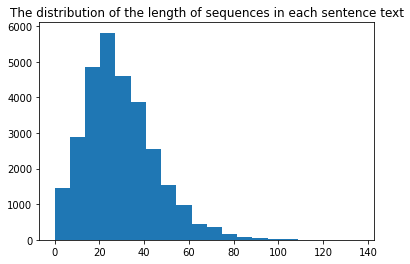

In [17]:
# get the distribution of the length of sequence in each sentence text
import matplotlib.pyplot as plt

plt.title("The distribution of the length of sequences in each sentence text")
plt.hist(seq_length, bins=20)
plt.xticks(np.arange(0, 150, 20))
plt.show()

In [18]:
# pad sequence (get the first 60/80 text sequence)
sequence_length = 60
x_train= sequence.pad_sequences(x_train_seq, maxlen=sequence_length, truncating='post', padding='post')
x_train= x_train[:, :sequence_length]

print(x_train)
print(x_train.shape)
print(x_train.dtype)

[[   1 1351   40 ...    0    0    0]
 [  27  102    2 ...    0    0    0]
 [ 741    2    3 ...    0    0    0]
 ...
 [1108  704  621 ...    0    0    0]
 [ 602    0    0 ...    0    0    0]
 [   3  201    4 ...    2    1 1360]]
(29681, 60)
int32


In [19]:
x1 = np.array(x_train)
np.any(np.isnan(x1))

False

### processing numbers ###

In [20]:
# the counts of the numbers in each sentence, get the distribution

max_number_seq = 0
num_seq_length = list()
for i in numbers:
    num_seq_length.append(len(i))
max_number_seq = max(num_seq_length)
print("max number sequence length: ", max_number_seq)


max number sequence length:  23


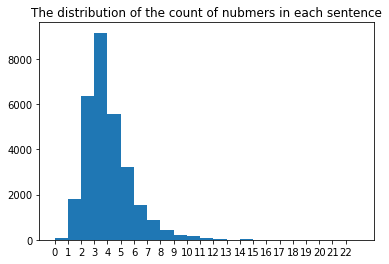

In [21]:
# get the distribution of the count of the nubmers
import matplotlib.pyplot as plt

plt.title("The distribution of the count of nubmers in each sentence")
plt.hist(num_seq_length, bins=max_number_seq)
plt.xticks(np.arange(max_number_seq))
plt.show()

In [22]:
# print(numbers)

for i in numbers:
    a = np.array(i)
    if np.any(np.isnan(a)):
        print("y")
    if np.any(np.isinf(a)):
        print("n")

In [23]:
# pad sequence (get the first 5 nubmers)
max_number_seq = 5
x_train_num = sequence.pad_sequences(numbers, dtype='float32', truncating='post', padding='post')
x_train_num = x_train_num[:, :max_number_seq]

print(x_train_num)
print(x_train_num.shape)
print(x_train_num.dtype)

[[ 3.0000e+00  1.0000e-01  3.6000e+01  0.0000e+00  0.0000e+00]
 [ 4.0000e+01  1.2000e+02  3.2000e+01  4.0000e+00  0.0000e+00]
 [ 6.6670e-01  9.0000e+01  0.0000e+00  0.0000e+00  0.0000e+00]
 ...
 [ 2.0000e+00  1.0000e+00 -2.3000e+01  0.0000e+00  0.0000e+00]
 [ 8.5184e+04  3.5200e+02  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 7.5100e+00  8.2200e+00  7.8600e+00  8.3600e+00  8.0900e+00]]
(29681, 5)
float32


In [24]:
y_train = train_ans
print(y_train)

0        400.0000
1        240.0000
2        270.0000
3          2.4000
4          0.5000
           ...   
29676      0.3333
29677     98.0000
29678    -12.0000
29679    242.0000
29680     12.0000
Length: 29681, dtype: float64


## 5. Model

In [25]:
# Load Glove vectors

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 300
glove_vec_file = 'dataset/glove.6B.300d.txt'
embedding_matrix = create_embedding_matrix(glove_vec_file, tok.word_index, embedding_dim)

In [26]:
vocab_size = len(tok.word_index) + 1
print(vocab_size)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
print(nonzero_elements / vocab_size)

8097
7572
0.9351611708040015


In [27]:
embedding_matrix.shape

(8097, 300)

### building model ###

In [28]:
LSTM_DIM = 16
DROPOUT = 0.1
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'
HIDDEN_DIM = 8

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, Input
from keras.layers.merge import concatenate

def buildModel(vsize, input_dim, maxlen, emb_matrix, maxnumbers):

    text_input = Input(shape=(maxlen, ))     
    numerical_input = Input(shape=(maxnumbers, ))
    
    emb = Embedding(input_dim=vsize, 
                   output_dim=input_dim, 
                   weights=[emb_matrix],
                   trainable=False)(text_input)
    
    z = LSTM(LSTM_DIM)(emb)
    z = Dropout(DROPOUT)(z)
    z = Dense(HIDDEN_DIM, activation=ACTIVATION)(z)
    
    numerical_input = Input(shape=(maxnumbers, ))
    
    merged = concatenate([z, numerical_input])    
    predictions = Dense(1, activation='linear')(merged)
    
    model = Model([text_input, numerical_input], outputs=predictions)
    
    model.compile(optimizer=OPTIMIZER,
                  loss = LOSS,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

model = buildModel(vocab_size, embedding_dim, sequence_length, embedding_matrix, max_number_seq)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      2429100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 16)           20288       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 16)           0           lstm[0][0]                       
______________________________________________________________________________________________

In [29]:
print(x_train.shape)
print(x_train_num.shape)
print(y_train.shape)

(29681, 60)
(29681, 5)
(29681,)


In [30]:
EPOCHS = 1

model.fit(
    x=[x_train, x_train_num],
    y=y_train,
    batch_size=50,
    validation_split=0.1,
    epochs=EPOCHS,
)

535/535 [==============================] - 12s 21ms/step - loss: nan - rmse: nan - val_loss: nan - val_rmse: nan


In [31]:
# del model

## 6. Evaluate the model

In [32]:
# model.evaluate(test_ds)

## 7. Make predictions

#### 1) processing test problems

In [33]:
def get_test_problems(test_df):
    # processing the test problem and separate the text and numbers
    
    test_problems = problem_processing(test_df['Problem'])
    print(test_problems)
    
    text = test_problems.apply(separate_text)
    numbers = test_problems.apply(separate_numbers)
    print(text)
    print(numbers)
    
    return text, numbers

#### 2) predicttion

In [34]:
# model.predict()

def prediction(model, tok, test_df, sequence_length, max_number_seq):
    
    # get the sequence of the text and numbers
    text, numbers = get_test_problems(test_df)
    
    x_test_seq = tok.texts_to_sequences(text)
    x_test_seq = sequence.pad_sequences(x_test_seq, maxlen=sequence_length, truncating='post', padding='post')
#     print(x_seq)
    print(x_test_seq.shape)
    
    x_test_num_seq = sequence.pad_sequences(numbers, maxlen=max_number_seq, dtype='float32', truncating='post', padding='post')
    x_tset_num_seq = x_test_num_seq[:, :max_number_seq]
    print(x_test_num_seq)
    
    output = model.predict([x_test_seq, x_test_num_seq]) 
    return output


In [35]:
# dummy test dataset
test_df = pd.DataFrame([
    {
        "Problem": "a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount had been offered ?",
        "Rationale": "\"giving no discount to customer implies selling the product on printed price . suppose the cost price of the article is 100 . then printed price = 100 \u00e3 \u2014 ( 100 + 31.1 ) / ( 100 \u00e2 \u02c6 \u2019 5 ) = 138 hence , required % profit = 138 \u00e2 \u20ac \u201c 100 = 38 % answer a\"",
        "options": "a ) 38 , b ) 27.675 , c ) 30 , d ) data inadequate , e ) none of these",
        "correct": "a",
        "annotated_formula": "subtract(divide(multiply(add(const_100, 31.1), const_100), subtract(const_100, 5)), const_100)",
        "linear_formula": "add(n1,const_100)|subtract(const_100,n0)|multiply(#0,const_100)|divide(#2,#1)|subtract(#3,const_100)|",
        "category": "gain"
    },
    {
        "Problem": "what will be the difference between simple and compound interest at 14 % per annum on a sum of rs . 1000 after 4 years ?",
        "Rationale": "\"s . i . = ( 1000 * 14 * 4 ) / 100 = rs . 560 c . i . = [ 1000 * ( 1 + 14 / 100 ) 4 - 1000 ] = rs . 689 difference = ( 689 - 560 ) = rs . 129 answer : a\"",
        "options": "a ) 129 , b ) 130 , c ) 124 , d ) 133 , e ) 145",
        "correct": "a",
        "annotated_formula": "subtract(subtract(multiply(1000, power(add(divide(14, const_100), const_1), 4)), 1000), multiply(multiply(1000, divide(14, const_100)), 4))",
        "linear_formula": "divide(n0,const_100)|add(#0,const_1)|multiply(n1,#0)|multiply(n2,#2)|power(#1,n2)|multiply(n1,#4)|subtract(#5,n1)|subtract(#6,#3)|",
        "category": "gain"
    },
    {
        "Problem": "there are 28 stations between hyderabad and bangalore . how many second class tickets have to be printed , so that a passenger can travel from any station to any other station ?",
        "Rationale": "\"the total number of stations = 30 from 30 stations we have to choose any two stations and the direction of travel ( i . e . , hyderabad to bangalore is different from bangalore to hyderabad ) in 3 \u2070 p \u2082 ways . 30 p \u2082 = 30 * 29 = 870 . answer : c\"",
        "options": "a ) 156 , b ) 167 , c ) 870 , d ) 352 , e ) 380",
        "correct": "c",
        "annotated_formula": "multiply(add(28, const_1), add(add(28, const_1), const_1))",
        "linear_formula": "add(n0,const_1)|add(#0,const_1)|multiply(#0,#1)|",
        "category": "physics"
    },
])

In [36]:
print(sequence_length)
print(max_number_seq)

# predict output -> the predict answer
predict_output = prediction(model, tok, test_df, sequence_length, max_number_seq)
print(predict_output)

60
5
0     a shopkeeper sold an article offering a disco...
1     what will be the difference between simple an...
2     there are 28 stations between hyderabad and b...
Name: Problem, dtype: object
0     a shopkeeper sold an article offering a disco...
1     what will be the difference between simple an...
2     there are stations between hyderabad and bang...
Name: Problem, dtype: object
0          [0.05, 0.311]
1    [0.14, 1000.0, 4.0]
2                 [28.0]
Name: Problem, dtype: object
(3, 60)
[[5.00e-02 3.11e-01 0.00e+00 0.00e+00 0.00e+00]
 [1.40e-01 1.00e+03 4.00e+00 0.00e+00 0.00e+00]
 [2.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00]]
[[nan]
 [nan]
 [nan]]


## 8. Calculate the distance

#### 1) get correct answer

In [37]:
cor_test_ans = get_correct_ans(test_df)
print(cor_test_ans)

num_test_ans = answers_processing(cor_test_ans)
print(num_test_ans)

0      38 
1     129 
2     870 
dtype: object
0     38.0
1    129.0
2    870.0
dtype: float64


#### 2) processing test options

In [38]:
def get_test_options(test_df):
    # processing the test options and separate each option
    
    test_options = list()
    opts_label = ['a', 'b', 'c', 'd', 'e']
    
    for i in range(len(test_df['options'])):
        options = test_df.iloc[i]['options']+" ,"
        answers = list()
        for j in opts_label:
            index_s = options.find(j+" ) ")+3
            index_len = options[index_s:].find(',')
            ans = options[index_s:index_s+index_len]
            answers.append(ans)
        answers = pd.Series(answers)
        # normalizing the options
        answers = answers_processing(answers)
        test_options.append(answers)
    return test_options


In [39]:
test_opts = get_test_options(test_df)
print(test_opts)

[0    38.000
1    27.675
2    30.000
3       NaN
4       NaN
dtype: float64, 0    129.0
1    130.0
2    124.0
3    133.0
4    145.0
dtype: float64, 0    156.0
1    167.0
2    870.0
3    352.0
4    380.0
dtype: float64]


In [40]:
def get_best_ans(opts, predict_output):
    # get the closest answer from teh options as the best answer
    dist = np.abs(predict_output - opts)
    print(dist)
    
    best_ans = np.min(dist)
    return best_ans

best_ans = get_best_ans(test_opts, predict_output)
print(best_ans)

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
nan
